<h1><center>DL Project (Food Recognition)</center></h1>
<center>Students should develop a software system aimed at recognising and segmenting food items in each image.</center>
<br>

<h3><center>Gee Jun Hui Leonidas Yunani<br>Marini Luca</center></h3>

<center>leonidas.gee@studio.unibo.it<br>luca.marini9@studio.unibo.it</center>
<br>

<center>Academic Year: 2020 / 2021</center>

In [1]:
# Install the pycoco library
!pip install pycocotools

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272450 sha256=21b1a1002c438d1d0c4fa4f8e16b51939a3c9d14f916c2703d28080c075e712e
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import random
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
%matplotlib inline
import imgaug.augmenters as iaa

In [3]:
# Set important parameters
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 300
EPOCHS = 5

In [4]:
# Define the image and annotation paths
train_imgs_path = '../input/food-recognition-challenge/train-v0.4/train/images'
train_anns_path = '../input/food-recognition-challenge/train-v0.4/train/annotations.json'

val_imgs_path = '../input/food-recognition-challenge/val-v0.4/val/images'
val_anns_path = '../input/food-recognition-challenge/val-v0.4/val/annotations.json'

test_imgs_path = '../input/food-recognition-challenge/test_images-v0.4/val/images'
test_anns_path = '../input/food-recognition-challenge/test_images-v0.4/val/annotations.json'

In [5]:
# Function to load JSON into a COCO api
def getCOCO(anns_path):
    # Initialize the COCO api for instance annotations
    coco = COCO(anns_path)
    
    # Load the categories in a variable
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print number of categories
    nms = [cat['name'] for cat in cats]
    
    # Create a dataframe of the count of each category
    df = pd.DataFrame(columns=['Category', 'ID', 'Count'])
    
    # Add each category and its count row by row
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        df.loc[i] = [nms[i]] + [catID] + [len(imgIds)]
    
    return coco, df

In [6]:
# Load the annotations of the image dataset
train_coco, train_classes = getCOCO(train_anns_path)
val_coco, val_classes = getCOCO(val_anns_path)
test_coco, test_classes = getCOCO(test_anns_path)

loading annotations into memory...
Done (t=2.64s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [7]:
def getMask(image_id, coco, classes, image_size):
    # Create a zero array with the given size and number of classes
    mask = np.zeros((image_size[0], image_size[1], 274))

    annIds = coco.getAnnIds(int(image_id))
    anns = coco.loadAnns(annIds)

    for i, ann in enumerate(anns):
        # Get the binary mask for the annotation
        binary = cv2.resize(coco.annToMask(ann), image_size, interpolation=cv2.INTER_AREA)

        # Get the channel index for the annotation
        channel = classes[classes.ID == ann['category_id']].index[0] + 1

        # Update the channel of the annotation
        mask[:, :, channel] = binary

        # Update the background channel of the annotation
        if i == 0:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], np.logical_not(binary))
        else:
            mask[:, :, 0] = np.logical_and(mask[:, :, 0], np.logical_not(binary))

    return mask

In [8]:
def getGenerator(path, coco, classes, image_size, batch_size, augment=False):
    c = 0
    n = os.listdir(path)
    random.shuffle(n)
    
    geo_aug = iaa.Fliplr(1.0)
    
    while (True):
        img_batch = np.zeros((batch_size, image_size[0], image_size[1], 3)).astype('int')
        mask_batch = np.zeros((batch_size, image_size[0], image_size[1], 274)).astype('float')

        for i in range(c, c + batch_size):
            img = cv2.imread(path + '/' + n[i])
            img =  cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            mask = getMask(n[i][1:-4], coco, classes, image_size)
            
            if augment == True:
                if random.random() < 0.5:
                    img = geo_aug(image=img)
                    mask = geo_aug(image=mask)            
            
            img_batch[i-c] = img
            mask_batch[i-c] = mask

        c += batch_size
        if(c + batch_size >= len(os.listdir(path))):
            c = 0
            random.shuffle(n)

        yield img_batch, mask_batch

In [9]:
# Get the generators from the paths
train_gen = getGenerator(train_imgs_path, train_coco, train_classes, IMAGE_SIZE, BATCH_SIZE, True)

train_length = len(os.listdir(train_imgs_path))
print('Number of training images: {}'.format(train_length))

val_gen = getGenerator(val_imgs_path, val_coco, val_classes, IMAGE_SIZE, BATCH_SIZE)

val_length = len(os.listdir(val_imgs_path))
print('Number of validation images: {}'.format(val_length))

test_gen = getGenerator(test_imgs_path, test_coco, test_classes, IMAGE_SIZE, BATCH_SIZE)

test_length = len(os.listdir(test_imgs_path))
print('Number of test images: {}'.format(test_length))

Number of training images: 24120
Number of validation images: 1269
Number of test images: 1269


In [10]:
def visualise(path, coco, classes, image_size, batch_size, augment=False):
    temp_gen = getGenerator(path, coco, classes, image_size, batch_size, augment)
    images, masks = next(temp_gen)
    
    for i in range(batch_size):
        plt.figure(figsize=(6, 16))
        
        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title('True Mask')
        
        true_mask = masks[i]
        for c in range(274):
            true_mask[:, :, c] = true_mask[:, :, c] * (c+1)
            
        plt.imshow(np.max(true_mask, axis=2))
        plt.axis('off')
        
        plt.show()

/opt/conda/lib/python3.7/site-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (48, 48, 274) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


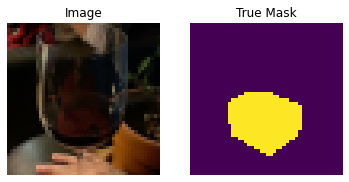

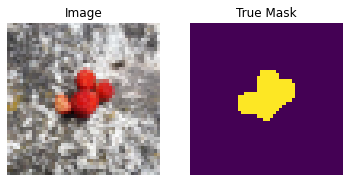

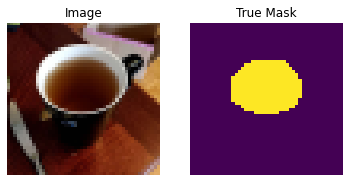

In [11]:
# Visualise a few samples images with their backgrounds and objects
visualise(train_imgs_path, train_coco, train_classes, IMAGE_SIZE, 3, True)

In [12]:
# Install and import the segmentation models library
!pip install segmentation_models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

     |████████████████████████████████| 50 kB 1.3 MB/s 
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [13]:
# Define the model to be trained
model = sm.PSPNet('efficientnetb7', encoder_weights='imagenet', encoder_freeze=True, 
                  input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), downsample_factor=4, 
                  classes=274, activation='softmax')

model.compile('Adam', loss=sm.losses.cce_dice_loss, 
              metrics=[sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])

258441216/258434480 [==============================] - 4s 0us/step


In [14]:
# Load the trained model weights
weights_path = '../input/food-recognition-model/weights (EfficientNet).h5'
model.load_weights(weights_path)

In [15]:
# Train the defined model on the dataset
history = model.fit(train_gen, steps_per_epoch=train_length//BATCH_SIZE, 
                    validation_data=val_gen, validation_steps=val_length//BATCH_SIZE, 
                    epochs=EPOCHS)

/opt/conda/lib/python3.7/site-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (48, 48, 274) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 1/5
80/80 [==============================] - 685s 9s/step - loss: 0.7224 - iou_score: 0.2603 - precision: 0.5365 - recall: 0.4577 - val_loss: 0.7367 - val_iou_score: 0.2539 - val_precision: 0.5215 - val_recall: 0.4488
Epoch 2/5
80/80 [==============================] - 522s 7s/step - loss: 0.7079 - iou_score: 0.2721 - precision: 0.5609 - recall: 0.4635 - val_loss: 0.7350 - val_iou_score: 0.2554 - val_precision: 0.5360 - val_recall: 0.4445
Epoch 3/5
80/80 [==============================] - 535s 7s/step - loss: 0.6968 - iou_score: 0.2815 - precision: 0.5697 - recall: 0.4709 - val_loss: 0.7471 - val_iou_score: 0.2454 - val_precision: 0.5444 - val_recall: 0.4195
Epoch 4/5
80/80 [==============================] - 527s 7s/step - loss: 0.6909 - iou_score: 0.2861 - precision: 0.5798 - recall: 0.4734 - val_loss: 0.7452 - val_iou_score: 0.2464 - val_precision: 0.5318 - val_recall: 0.4164
Epoch 5/5
80/80 [==============================] - 524s 7s/step - loss: 0.6822 - iou_score: 0.2937 - pre

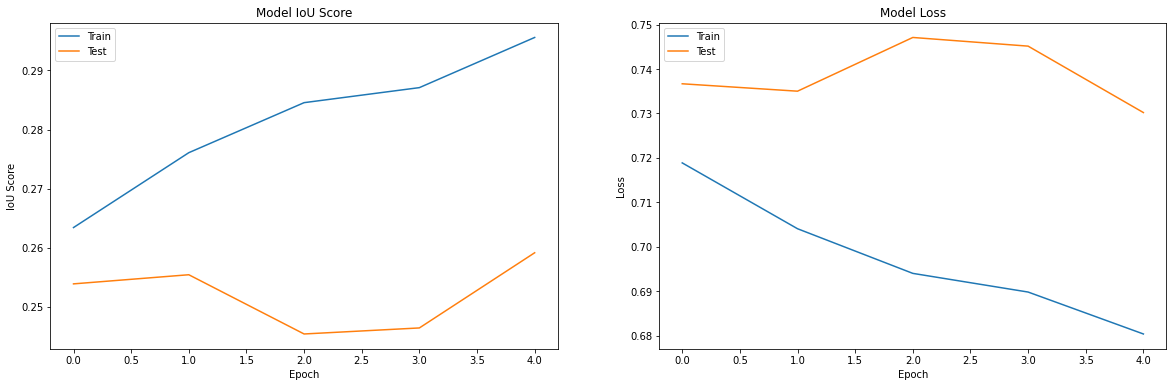

In [16]:
# Plot the loss and iou score over the epochs
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IoU Score')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
# Save the model to the output
model.save_weights('weights.h5')

In [18]:
# Evaluate the model on the test generator
scores = model.evaluate(test_gen, steps=test_length//BATCH_SIZE)
print('\nLoss: {}'.format(round(scores[0], 3)))
print('IoU: {}'.format(round(scores[1], 3)))
print('Precision: {}'.format(round(scores[2], 3)))
print('Recall: {}'.format(round(scores[3], 3)))

4/4 [==============================] - 25s 8s/step - loss: 0.7304 - iou_score: 0.2588 - precision: 0.5458 - recall: 0.4343

Loss: 0.73
IoU: 0.259
Precision: 0.546
Recall: 0.434


In [19]:
def predict(model, path, coco, classes, image_size, batch_size):
    temp_gen = getGenerator(path, coco, classes, image_size, batch_size)
    images, masks = next(temp_gen)
    prediction = model.predict(images)
    
    for i in range(batch_size):
        plt.figure(figsize=(10, 20))
        
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        
        true_mask = masks[i]
        for c in range(274):
            true_mask[:, :, c] = true_mask[:, :, c] * (c+1)
            
        plt.imshow(np.max(true_mask, axis=2))
        plt.axis('off')
        
        pred_mask = np.round(prediction[i])
        for c in range(274):
            pred_mask[:, :, c] = pred_mask[:, :, c] * (c+1)
            
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(np.max(pred_mask, axis=2))
        plt.axis('off')
        
        plt.show()

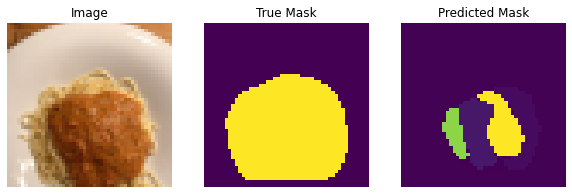

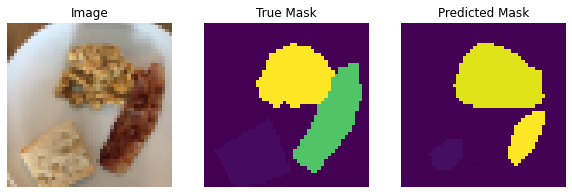

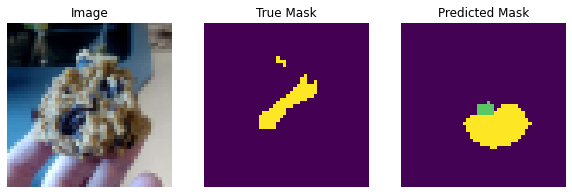

In [20]:
# Visualise the predictions and the true masks
predict(model, test_imgs_path, test_coco, test_classes, IMAGE_SIZE, 3)